In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import keras
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 200
BASE_DIR = '../project/all_females'

In [3]:
def prepareData(percentage,rating_path):
    # Read in ratings
    ratings = np.genfromtxt(rating_path)
    
    # Round (obviously imbalanced sets)
    ratings = np.round(ratings, 0).astype(np.int8)
    print(np.unique(ratings, return_counts=True))
    
    ### Distribute images across folders
    for r in np.unique(ratings).astype(np.int8):
        if not os.path.isdir('./data/train/{}-stars'.format(r)):
            os.makedirs('./data/train/{}-stars'.format(r))
        if not os.path.isdir('./data/test/{}-stars'.format(r)):
            os.makedirs('./data/test/{}-stars'.format(r))
                
    ### Move all images according to ratings
    images = sorted(os.listdir(BASE_DIR))

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]

    for i in test_ind:
        src = os.path.join(BASE_DIR, images[i])
        dest = os.path.join('./data/test/{}-stars'.format(ratings[i]), images[i])
        shutil.copy(src, dest)
        
    for i in train_ind:
        src = os.path.join(BASE_DIR, images[i])
        dest = os.path.join('./data/train/{}-stars'.format(ratings[i]), images[i])
        shutil.copy(src, dest)
        
    return ratings[train_ind], train_ind, ratings[test_ind], test_ind, ratings, images

In [4]:
def getGenerator():
    datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                preprocessing_function=utils.preprocess_input)

    train_generator = datagen.flow_from_directory(
                                './data/train/',
                                target_size=(IMG_SIZE, IMG_SIZE),
                                batch_size=64,
                                class_mode='categorical'#, save_to_dir='aug_data/train', save_prefix='aug_train', save_format='png'
                                )

    test_generator = datagen.flow_from_directory(
                            './data/test/',
                            target_size=(IMG_SIZE, IMG_SIZE),
                            batch_size=64,
                            class_mode='categorical'#, save_to_dir='aug_data/test', save_prefix='aug_test', save_format='png'
                            )

    return train_generator, test_generator

In [8]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [46]:
def recommend(images, pred_classes):
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(BASE_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

In [5]:
y_train, train_ind, y_test, test_ind, ratings, images = prepareData(5,'./ratings_stefan.txt')
train_generator, test_generator = getGenerator()

(array([0, 1, 2, 3, 4, 5], dtype=int8), array([105, 170, 125,  83,  80,   5]))
Found 540 images belonging to 6 classes.
Found 28 images belonging to 6 classes.


In [6]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation='relu', name='fc6')(last_layer)
X = Dropout(0.2)(X)
X = Dense(128, activation='relu', name='fc7')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation='relu', name='fc8')(X)
X = Dropout(0.2)(X)
output = Dense(len(np.unique(ratings)), activation='softmax')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False
    
# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-v3.2.1-stefan.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [7]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=540//64,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator,
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
8/8 [==============================] - 11s 1s/step - loss: 1.7691 - acc: 0.2002 - val_loss: 1.6679 - val_acc: 0.2857

Epoch 00001: val_loss improved from inf to 1.66788, saving model to ./weights-v3.2.1-stefan.hdf5
Epoch 2/500
8/8 [==============================] - 5s 642ms/step - loss: 1.6996 - acc: 0.2739 - val_loss: 1.6257 - val_acc: 0.2857

Epoch 00002: val_loss improved from 1.66788 to 1.62566, saving model to ./weights-v3.2.1-stefan.hdf5
Epoch 3/500
8/8 [==============================] - 5s 646ms/step - loss: 1.6357 - acc: 0.2941 - val_loss: 1.6133 - val_acc: 0.3214

Epoch 00003: val_loss improved from 1.62566 to 1.61328, saving model to ./weights-v3.2.1-stefan.hdf5
Epoch 4/500
8/8 [==============================] - 6s 693ms/step - loss: 1.6065 - acc: 0.2871 - val_loss: 1.6234 - val_acc: 0.2857

Epoch 00004: val_loss did not improve
Epoch 5/500
8/8 [==============================] - 5s 649ms/step - loss: 1.6127 - acc: 0.2751 - val_loss: 1.6073 - val_acc: 0.2857

Epoch

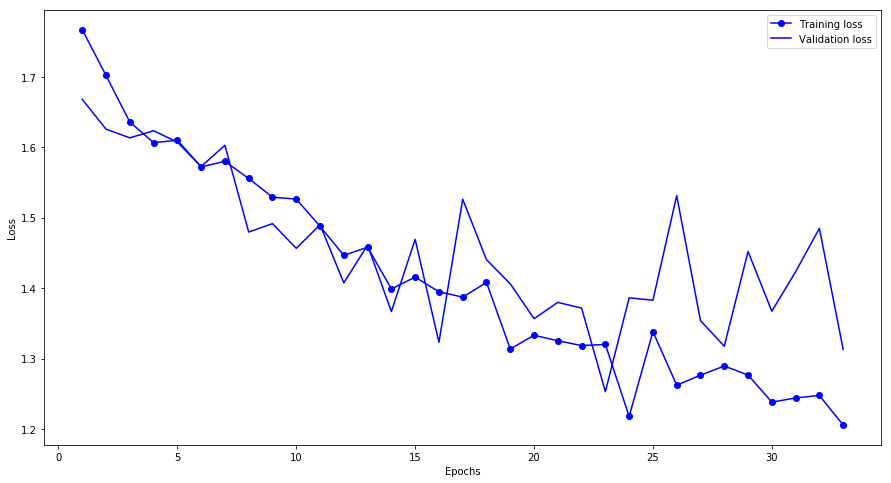

In [10]:
visualize_loss(history)

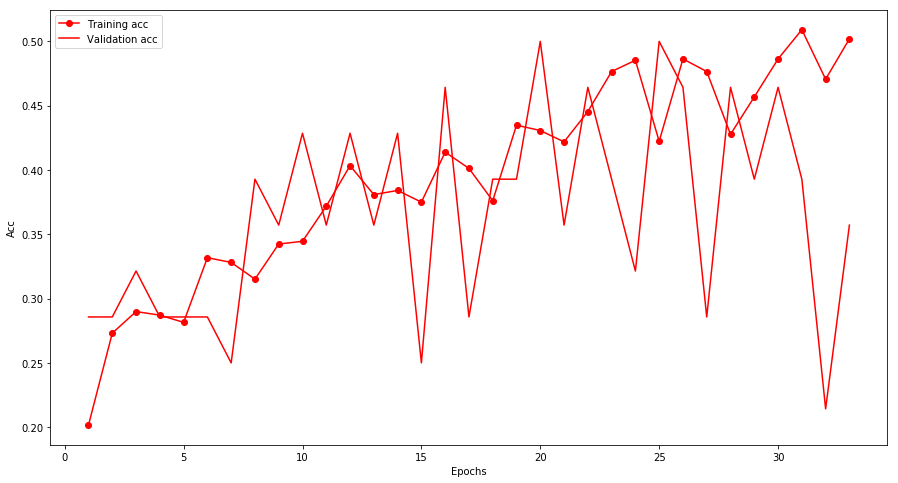

In [11]:
visualize_acc(history)

In [12]:
model.save('./models/love_classifierv3.2.1-stefan.h5')

In [49]:
#get test data (unmodified)
data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
last_set = 0

for idx, _im in enumerate(images): #iterate over images
    if idx in test_ind:
        _img = image.load_img(os.path.join(BASE_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data_test[last_set, :, :, :] = utils.preprocess_input(_x, version=1) / .255
        last_set += 1
    
predictions = model.predict(data_test)
pred_classes = predictions.argmax(axis=-1)

y_true = np.array(y_test)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

[1 3 1 3 2 0 1 3 0 0 1 4 1 1 0 0 4 3 2 1 2 3 0 1 4 0 0 2]
[1 0 0 4 2 4 1 0 3 0 0 3 0 2 1 1 1 2 4 2 1 2 3 2 2 1 2 4]


array([[1, 3, 1, 2, 1],
       [3, 2, 3, 0, 0],
       [0, 1, 1, 0, 2],
       [2, 0, 2, 0, 1],
       [0, 1, 1, 1, 0]])

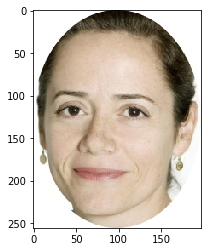

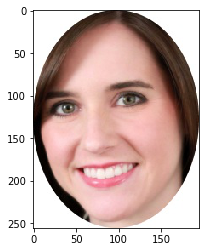

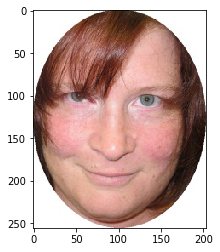

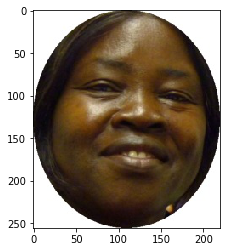

In [47]:
recommend(images,pred_classes)